In [ ]:
!pip install chart-studio

* 참고한 커널 <br>
[링크1](https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series?fbclid=IwAR2bO4aJEY5M9GZPfrpzqS2dRwbbE9o6kkjPvEvDj7WyaGyW8sVjOh2DgQ8) <br>
[링크2](https://nbviewer.org/gist/subinium/26d22a786b0b7d088da63a97bf8e1d44?fbclid=IwAR1qb8jOUHhXJWCBoijD8giJ9DeKew0T5VwIrzdS4bk2RLyfPo8WmIu6sAg)

In [ ]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline

from pylab import rcParams
from plotly import tools
#import plotly.plotly as py
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
print(os.listdir("../input"))

# 1. Introduction to date and time

## 1.1 Importing time series data

**How to import data?**

First, we import all the datasets needed for this kernel. The required time series column is imported as a datetime column using **parse_dates** parameter and is also selected as index of the dataframe using **index_col** parameter.

Data being used:-
1. Google Stocks Data
2. Humidity in different world cities
3. Microsoft Stocks Data
5. Pressure in different world cities

### parse_dates
csv 의 특정 컬럼 중 날짜형태(yyyy-MM-dd hh:mi:ss) 로 표시되어 있어도 csv를 불러오면 object(string) 형태로 선언되어 있다. 이전까지는 padnas.to_datetime 을 이용해서 형태를 바꿨는데 데이터가 1000만 건이상이 되면 변환해주는것도 시간이 꽤 소요된다.

그래서 옵션을 추가해 처음 로드할때 부터 데이터타입을 맞추는게 더 효율적이다.

read_csv를 이용할때 옵션을 주면 datetime 형태로 로드가 가능하다

In [ ]:
google = pd.read_csv('../input/stock-time-series-20050101-to-20171231/GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
google.head()

In [ ]:
humidity = pd.read_csv('../input/historical-hourly-weather-data/humidity.csv', index_col='datetime', parse_dates=['datetime'])
humidity.tail()

## 1.2 Cleaning and preparing time series data

**How to prepare data?**

Google stocks data doesn't have any missing values but humidity data does have its fair share of missing values. It is cleaned using **fillna()** method with **ffill** parameter which propagates last valid observation to fill gaps

ffill : 앞의 값을 관찰한 값으로 채워넣음 <br>
bfill : 뒤의 값을 관찰한 값으로 채워넣음

In [ ]:
humidity.head()

In [ ]:
humidity.iloc[1:]

In [ ]:
humidity = humidity.iloc[1:]
humidity = humidity.fillna(method='ffill')
humidity.head()

## 1.3 Visualizing the datasets

**asfreq** 메서드는 시계열을 특정 frequency로 변환합니다. (30S = 30초, M = 매월) upsampling 또는 downsampling에 사용할 수 있습니다.

여기서는 매개변수를 'M'으로 전달하였고, 이는 매월 빈도를 의미합니다

In [ ]:
humidity["Kansas City"].asfreq('M').plot() # asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
plt.title('Humidity in Kansas City over time(Monthly frequency)')
plt.show()

In [ ]:
humidity["Kansas City"].asfreq('Y').plot() # asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
plt.title('Humidity in Kansas City over time(Monthly frequency)')
plt.show()

In [ ]:
google['2008':'2010'].plot(subplots=True, figsize=(10,12))
plt.title('Google stock attributes from 2008 to 2010')
plt.savefig('stocks.png')
plt.show()

## 1.4 Timestamps and Periods

**What are timestamps and periods and how are they useful?**

timestamp와 period는 무엇이고, 어떻게 유용할까요?

* **Timestamp**는 특정 시점을 나타내기 위해 사용됩니다.

* **Period**는 특정 기간을 나타내기 위해 사용됩니다.

Periods는 기간동안 특정 이벤트가 있는지 체크하는데 사용할 수 있습니다. 각각은 서로 변환가능합니다. 우선 아래 예시로 생성 방법을 살펴보겠습니다.

In [ ]:
# Creating a Timestamp
timestamp = pd.Timestamp(2017, 1, 1, 12)
timestamp

In [ ]:
# Creating a period
period = pd.Period('2017-01-01')
period

timestamp와 period는 이런 비교가 가능합니다.

In [ ]:
# Checking if the given timestamp exists in the given period
period.start_time < timestamp < period.end_time

In [ ]:
period.start_time

In [ ]:
period.end_time

변환의 예시는 다음과 같습니다.

In [ ]:
# Converting timestamp to period
new_period = timestamp.to_period(freq='H')
new_period

In [ ]:
new_period.end_time

In [ ]:
# Converting period to timestamp
new_timestamp = period.to_timestamp(freq='H', how='start')
new_timestamp

## 1.5 Using date_range

**What is date_range and how is it useful?** <br>
date_range는 무엇이고, 어떻게 유용할까요?

**date_range**는 고정 frequency datetimeindex를 반환하는 메서드입니다. 이것도 예시를 봐야 이해가 빠를 것 같습니다.

이는 기존 데이터에서 본인만의 시계열 요소를 만들거나 전체 데이터를 정리(arranging)하는데 사용할 수 있습니다.

In [ ]:
# Creating a datetimeindex with daily frequency
dr1 = pd.date_range(start='1/1/18', end='1/9/18')
dr1

In [ ]:
# Creating a datetimeindex with monthly frequency
dr2 = pd.date_range(start='1/1/18', end='1/1/19', freq='M')
dr2

아래와 같이 시작과 종료 시점 중 하나만 있어도 되고, 원하는 period에서 시계열을 만들 수 있습니다

In [ ]:
# Creating a datetimeindex without specifying start date and using periods
dr3 = pd.date_range(end='1/4/2014', periods=8)
dr3

In [ ]:
# Creating a datetimeindex specifying start date , end date and periods
dr4 = pd.date_range(start='2013-04-24', end='2014-11-27', periods=3)
dr4

## 1.6 Using to_datetime

**pandas.to_datetime()**은 Dataframe을 datetime으로 변환하는 함수입니다

In [ ]:
df = pd.DataFrame({'year': [2015, 2016], 'month': [2, 3], 'day': [4, 5]})
df

In [ ]:
df.info()

In [ ]:
df = pd.to_datetime(df)
df

In [ ]:
df = pd.to_datetime('01-01-2017')
df

## 1.7 Shifting and lags

우리는 원하는 기간을 shift하여 index를 원하는 frequency로 이동변환 가능합니다.

이는 과거와 현재의 시계열을 비교하는데 유용합니다.

아래는 데이터를 월 단위로 바꾼 후에 10개월을 shift한 후 시각화한 그래프입니다.

In [ ]:
humidity["Vancouver"].asfreq('M').plot(legend=True)
shifted = humidity["Vancouver"].asfreq('M').shift(10).plot(legend=True)
shifted.legend(['Vancouver','Vancouver_lagged'])
plt.show()

## 1.8 Resampling

**Upsampling** : 시계열을 low frequency에서 high frequency로 변환(리샘플링)합니다. 누락된 데이터를 채우거나 보간하는 방법을 포함합니다. (월 데이터 -> 일 데이터)

**Downsampling** : 시계열을 high frequency에서 low frequency로 변환(리샘플링)합니다. 기존 데이터를 집계하는 것을 포함합니다. (주간 데이터 -> 월 데이터)

In [ ]:
# Let's use pressure data to demonstrate this
pressure = pd.read_csv('../input/historical-hourly-weather-data/pressure.csv', index_col='datetime', parse_dates=['datetime'])
pressure.tail()

시작부터 채워야하는 데이터들이 보입니다. 이는 다음과 같이 채울 수 있습니다.

In [ ]:
pressure = pressure.iloc[1:]
pressure = pressure.fillna(method='ffill')
pressure.tail()

In [ ]:
pressure = pressure.fillna(method='bfill')
pressure.head()

* **ffill** 파라미터를 사용하면 마지막 유효 관측치를 전파하여 데이터의 갭을 채웁니다.
* **bfill** 파라미터를 사용하면 다음 유효 관측치를 전파하여 데이터의 갭을 채웁니다.

In [ ]:
# Shape before resampling(downsampling)
pressure.shape

기존 데이터는 **1시간 단위**로 존재했습니다. 이를 3일 단위로 **다운샘플링**해보겠습니다. resample 메서드를 사용했고, 평균을 사용했습니다.

In [ ]:
# We downsample from hourly to 3 day frequency aggregated using mean
pressure = pressure.resample('3D').mean()
pressure.head()

아래와 같이 데이터 수가 1/72가 된 것을 확인할 수 있습니다.

In [ ]:
# Shape after resampling(downsampling)
pressure.shape

이제 이를 역으로 3일간격을 1일 간격으로 **업샘플링**해보겠습니다. pad()는 패딩을 의미합니다

In [ ]:
pressure = pressure.resample('D').pad()
pressure.head()

In [ ]:
# Shape after resampling(upsampling)
pressure.shape

행의 수가 증가하지만, **데이터가 손실되는 것을 확인**할 수 있었습니다.

resampling은 필요에 따라 매우 유용하게 사용할 수 있습니다.

# 2. Finance and statistics

## 2.1 Percent change
시계열에서 각 데이터가 이전에 비해 변한 정도를 나타내는 코드입니다.

shift()를 이용해 dataframe에서 최소 단위로 shift를 진행하고, div 메서드로 앞의 값을 나눠주는 방식입니다.

In [ ]:
google.High

In [ ]:
google.High.shift()

In [ ]:
google.High.div(google.High.shift())

In [ ]:
google['Change'] = google.High.div(google.High.shift())
google['Change'].plot(figsize=(20,8))

## 2.2 Stock returns

전과 price가 같다면, 변한 정도는 1로 표기될 것입니다.

그렇기에 (비율-1) * 100 의 식을 사용하여 %로 변환합니다.

In [ ]:
google['Return'] = google.Change.sub(1).mul(100)
google['Return'].plot(figsize=(20,8))

한 줄로 쓰면 다음과 같이 쓸 수 있습니다.

In [ ]:
google.High.pct_change().mul(100).plot(figsize=(20,6)) # Another way to calculate returns

## 2.3 Absolute change in successive rows

값 자체의 차이는 diff()를 사용하여 구할 수 있습니다.

In [ ]:
google.High.diff().plot(figsize=(20,6))

In [ ]:
google.High.diff()


In [ ]:
google.High

## 2.4 Comaring two or more time series

normalization을 통해 2개의 시계열을 비교해보겠습니다.

두 개의 시계열을 각 시계열의 첫 번째 요소로 나누어주어, 비율의 변화를 보는 방법입니다. 두 시리즈의 시작점이 1.0으로 같아 비교가 용이합니다.

이제 구글 주식과 함께 MS 주식 데이터를 불러오겠습니다.

In [ ]:
# We choose microsoft stocks to compare them with google
microsoft = pd.read_csv('../input/stock-time-series-20050101-to-20171231/MSFT_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

아래는 nomalization 전의 그래프입니다.

In [ ]:
# Plotting before normalization
google.High.plot()
microsoft.High.plot()
plt.legend(['Google','Microsoft'])
plt.show()

아래는 변환 후 그래프입니다.

In [ ]:
# Normalizing and comparison
# Both stocks start from 100
normalized_google = google.High.div(google.High.iloc[0]).mul(100)
normalized_microsoft = microsoft.High.div(microsoft.High.iloc[0]).mul(100)
normalized_google.plot()
normalized_microsoft.plot()
plt.legend(['Google','Microsoft'])
plt.show()

변환을 통해 확인한 그래프에서 시간에 따른 google의 실적이 MS의 실적보다 뛰어난 것을 명확하게 확인할 수 있습니다.

In [ ]:
google.High.iloc[0]

In [ ]:
google.High.div(google.High.iloc[0]).mul(100)

## 2.5 Window functions

**Window functions**는 서브-기간을 식별하고, 서브-기간간의 연산에 사용합니다.

**Rolling** : 일정 구간에서 움직이며 값의 경향성을 구함

**Expanding** : Contains all prior values

아래는 각 데이터를 90일 window를 이동시키며 평균으로 ploting한 예시입니다.

In [ ]:
# Rolling window functions
rolling_google = google.High.rolling('90D').mean()
google.High.plot()
rolling_google.plot()
plt.legend(['High','Rolling Mean'])
# Plotting a rolling mean of 90 day window with original High attribute of google stocks
plt.show()

원본보다 롤링한 값이 부드러운 것을 확인할 수 있습니다.

In [ ]:
pd.options.display.max_rows = 100

In [ ]:
google.High.rolling(90).mean()[:100]

In [ ]:
google.High.rolling('90D').mean()[:100]

In [ ]:
google.High

### rolling 함수
rolling(24).mean() 일때,
yt의 이전 데이터 23개와 자기 자신 데이터 (총 24개) 를 가져와서 평균낸 것이다.

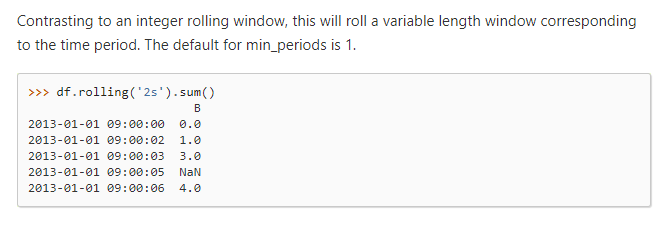

**min_periods** 

정수 매개 변수입니다. 이 매개 변수는 윈도우의 최소 관측치 수를 지정합니다. 관찰 수에는 값이 있어야합니다. 그렇지 않으면 결과는 널값입니다.

아래는 **expanding** 예시입니다. default값은 1입니다.

=> 사이즈 키워가며 연산 

ex) 평균 내기 (1,2) 평균 (1,2,3) 평균 (1,2,3,4) 평균 ....

In [ ]:
# Expanding window functions
microsoft_mean = microsoft.High.expanding().mean()
microsoft_std = microsoft.High.expanding().std()
microsoft.High.plot()
microsoft_mean.plot()
microsoft_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

In [ ]:
microsoft.High

In [ ]:
microsoft.High.expanding().mean()

In [ ]:
microsoft.High.expanding().std()

## 2.6 OHLC charts

**OHLC 차트**는 고가(high), 저가(low), 시가(open), 종가(close)를 보여주는 모든 유형의 가격 차트입니다. OHLC 차트는 증권, 통화, 주식, 채권, 원자재 등의 시간 경과에 따른 가격 변동을 시각화하고 분석하는 거래 도구(trading tool)로 사용됩니다. OHLC 차트는 시작의 매일 상태를 해석하고, 형성된 패턴에서 미래의 가격 변화를 예측하는데 유용합니다.

OHLC 차트에서 y축은 가격을, x축은 시간을 나타냅니다. 각 단일 기간에서 OHLC 차트는 최고가, 최저가, 시가와 종가를 기호를 이용해 나타내야합니다. 각 기간에서 고가와 저가는 세로선의 길이로 표시됩니다. 시가는 세로선의 왼쪽에 종가는 오른쪽에 표시됩니다.

종가가 시가보다 높은 경우(bullish)와 종가가 시가보다 낮은 경우(bearish)를 색으로 구분하여 표시할 수도 있습니다.

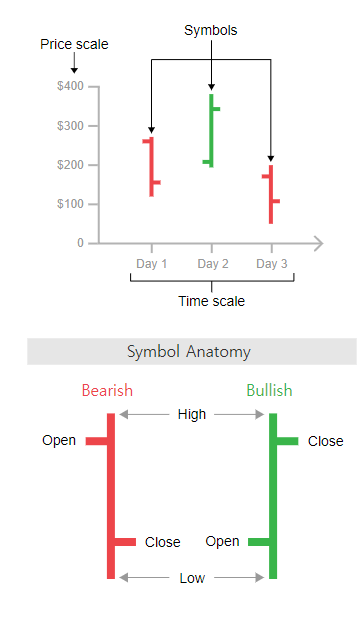

이제 plotly.graph_objs 모듈을 사용하여 Ohlc 차트를 그려보겠습니다.

Source: [Datavizcatalogue](http://https://datavizcatalogue.com/methods/OHLC_chart.html)

* 2008년 6월 데이터

In [ ]:
# OHLC chart of June 2008
trace = go.Ohlc(x=google['06-2008'].index,
                open=google['06-2008'].Open,
                high=google['06-2008'].High,
                low=google['06-2008'].Low,
                close=google['06-2008'].Close)
data = [trace]
iplot(data, filename='simple_ohlc')

* 2008년 데이터

In [ ]:
# OHLC chart of 2008
trace = go.Ohlc(x=google['2008'].index,
                open=google['2008'].Open,
                high=google['2008'].High,
                low=google['2008'].Low,
                close=google['2008'].Close)
data = [trace]
iplot(data, filename='simple_ohlc')

* 2006년~2018년 데이터

In [ ]:
# OHLC chart of 2006 ~ 2017
trace = go.Ohlc(x=google.index,
                open=google.Open,
                high=google.High,
                low=google.Low,
                close=google.Close)
data = [trace]
iplot(data, filename='simple_ohlc')

## 2.7 Candlestick charts
이 유형의 차트는 OHLC차트와 마찬가지로 증권, 파생 상품, 통화, 주식, 채권, 상품 등에 대한 시간 경과에 따른 가격 변동을 시각화하고 분석하는 거래 도구로 사용됩니다. Candlestick차트에 사용된 기호는 Box Plot과 유사하나 기능이 다르므로 혼동하면 안됩니다.

Candlestick 차트는 촛대 모양의 기호를 사용하여 시가, 종가, 고가, 저가 등의 가격 정보의 여러 비트를 표현합니다. 각 기호는 단일 기간(분, 시, 일, 월 등)에 대한 거래 활동을 압축하여 표현합니다. 각 촛대 기호는 시간 경과에 따른 거래 활동을 보여주기 위해 x축(시간)을 따라 표시됩니다.

메인 직사각형(a.k.a real body)은 해당 기간의 시가와 종가와 그 범위를 보여줍니다. 그 외의 위와 아래 그림자(또는 심지)는 해당 기간의 거래된 최고가와 최저가를 나타냅니다. 종가가 시가보다 높은 경우(bullish)와 종가가 시가보다 낮은 경우(bearish)를 색으로(하얀 또는 초록 | 검정 또는 빨강) 구분하여 표시할 수도 있습니다.

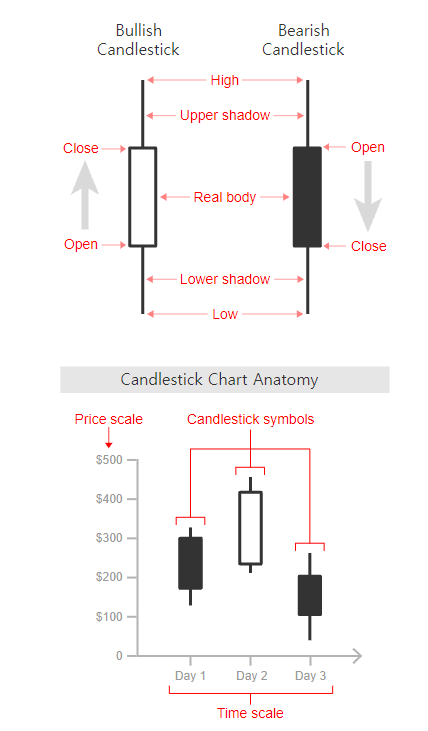

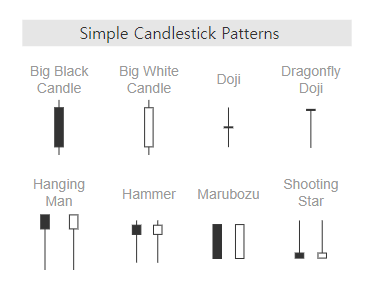

Candlestick 차트는 시간에 따른 시장 트렌드를 감지하고 예측하는데 유용하고, 각 촛대의 기호와 색상을 통해 시장 상태를 해석하는 데 유용합니다. 예시로 몸통이 길수록 구매와 판매가 활발했으며, 몸통이 짧은 경우 가격 변동이 거의 없고 거래가 적었음을 의미합니다.

Candlestick 차트는 모양과 색상과 같은 다양한 지표를 통해 시장 심리나 여러 패턴을 확인하는데 도움을 줍니다. 총 42개의 패턴이 있고, 이는 단순한 패턴과 복잡한 패턴으로 나뉩니다. 여기서 발견된 패턴은 가격 관계를 표시하거나 향후 시장의 변화를 예측하는 사용할 수 있습니다. 위에 단순한 패턴의 예시를 가져왔으니 가볍게 보면 좋을 것 같습니다.

차트는 시가와 종가 사이에서 발생하는 이벤트를 표현하지 않습니다. 두 가격간의 관계만 나타냅니다. 그렇기에 우리는 특정 단일 기간 내에 얼마나 많은 휘발성 거래가 있었는지 말할 수는 없습니다.

Source: [Datavizcatalogue](https://datavizcatalogue.com/methods/candlestick_chart.html)

* 2008년 3월 데이터

In [ ]:
# Candlestick chart of march 2008
trace = go.Candlestick(x=google['03-2008'].index,
                open=google['03-2008'].Open,
                high=google['03-2008'].High,
                low=google['03-2008'].Low,
                close=google['03-2008'].Close)
data = [trace]
iplot(data, filename='simple_candlestick')

* 2008년 데이터

In [ ]:
# Candlestick chart of 2008
trace = go.Candlestick(x=google['2008'].index,
                open=google['2008'].Open,
                high=google['2008'].High,
                low=google['2008'].Low,
                close=google['2008'].Close)
data = [trace]
iplot(data, filename='simple_candlestick')

* 2006년 ~ 2018년 데이터

In [ ]:
# Candlestick chart of 2006-2018
trace = go.Candlestick(x=google.index,
                open=google.Open,
                high=google.High,
                low=google.Low,
                close=google.Close)
data = [trace]
iplot(data, filename='simple_candlestick')

## 2.8 Autocorrelation and Partial Autocorrelation
* **Autocorrelation** : The autocorrelation function (ACF)은 lags만큼 이동시킨 자기자신과의 공분산을 의미합니다. 정확히는 공분산을 normalization한 값입니다. 현재와 과거의 연관성을 확인할 수 있습니다. 자기상관이라고도 합니다.

* **Partial Autocorrelation** : 부분적인 autocorrelation을 의미합니다. 편자기상관함수라고도 불립니다. 시간단위로 구분된 시계열간의 자기상관도를 확인합니다.

일반적으로 추세를 확인하고 이동 평균 매개 변수의 가능한 값을 추론하는 데 ACF를 사용하고 자동 회귀 부분에는 PACF를 사용합니다.

Source: [Quora](https://www.quora.com/What-is-the-difference-among-auto-correlation-partial-auto-correlation-and-inverse-auto-correlation-while-modelling-an-ARIMA-series)

## Autocorrelation

In [ ]:
# Autocorrelation of humidity of San Diego
plot_acf(humidity["San Diego"],lags=25,title="San Diego")
plt.show()

모든 지연은 1에 가깝거나 또는 적어도 신뢰 구간보다 크므로 통계적으로 유의합니다.

## Partial Autocorrelation

In [ ]:
# Partial Autocorrelation of humidity of San Diego
plot_pacf(humidity["San Diego"],lags=25)
plt.show()

처음 2개 이후 매우 낮은 값을 가집니다

In [ ]:
# Partial Autocorrelation of closing price of microsoft stocks
plot_pacf(microsoft["Close"],lags=25)
plt.show()

여기서 0번째, 1번째 및 20번째 lags만 통계적으로 중요합니다

# 3. Time series decomposition and Random walks
## 3.1. Trends, seasonality and noise
시계열에는 다음과 같은 요소가 있습니다.

* Trend : 시계열에서 일정한 상승 또는 하강 기울기
* Seasonality : 시계열에서 명확한 패턴 (사인함수와 같이)
* Noise : 특이점(Outliers) 또는 누락 데이터

In [ ]:
# Let's take Google stocks High for this
google["High"].plot(figsize=(16,8))

import statsmodels.api as sm 로 이런 경향성을 확인해보겠습니다.


In [ ]:
# Now, for decomposition...
rcParams['figure.figsize'] =11,9
decomposed_google_volume = sm.tsa.seasonal_decompose(google['High'], freq =360)
figure = decomposed_google_volume.plot()
plt.show()

* 위 그래프에서는 분명한 상승 trend가 있습니다.
* seasonal change는 균일한 것을 확인할 수 있습니다.
* 특이점과 누락 데이터는 균일하지 않은 것을 확인할 수 있습니다.

## 3.2. White noise
시계열 분석에서 White noise는 서로 독립적이고 평균과 분산이 일정한 잡음입니다. 자기상환함수나 편자기상관함수의 값이 유의수준보다 작으면 백색잡음으로 판단합니다.

White noise는 다음과 같은 성질을 가지고 있습니다. 많은 수계열 모형들의 불규칙한 패턴을 의미하고, 정규분포에서 추출된 임의의 수치라고 규정하고 있습니다. 모델의 해석을 전반적으로 편리하게 만듭니다.

* Constant mean : 일정한 평균
* Constant variance : 일정한 분산
* Zero auto-correlation at all lags : 모든 lag에 대해 자기상관계수가 0

아래는 white noise 예시입니다.

In [ ]:
# Plotting white noise
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
# loc is mean, scale is variance
plt.plot(white_noise)

In [ ]:
# Plotting autocorrelation of white noise
plot_acf(white_noise,lags=20)
plt.show()

## 3.3. Random Walk

**random walk**는 확률론적 랜덤 프로세스로, 단순한 시뮬레이션 입니다. 시계열에서 주식, 정수(integer)과 같은 수 단위의 시스템에서 다음 행동의 확률을 통해 미래를 예측하는 모델링입니다.

주식에서는 보통 다음과 같은 형태가 나타납니다

Today's Price = Yesterday's Price + Noise

즉, 오늘의 가격은 어제의 가격 + 노이즈인거죠.

**Pt = Pt-1 + εt**

Random walk는 미래를 예측하는데 적합하지는 않습니다. 왜냐하면 노이즈 값은 랜덤이기 때문입니다. 아래는 Random Walk에 대한 가설과 검정 예시입니다. (귀무가설과 대립가설)

Random Walk with Drift(drift(μ) is zero-mean)

**Pt - Pt-1 = μ + εt**

Regression test for random walk

**Pt = α + βPt-1 + εt
Equivalent to Pt - Pt-1 = α + βPt-1 + εt**

Test:

**H0: β = 1 (This is a random walk)
H1: β < 1 (This is not a random walk)**

Dickey-Fuller Test:

**H0: β = 0 (This is a random walk)
H1: β < 0 (This is not a random walk)**

### Augmented Dickey-Fuller test
An augmented Dickey–Fuller test (ADF)는 시계열 샘플에서 단위근이 존재한다는 검정 방법입니다. Dickey-Fuller에서 lag를 보다 확장하여 사용할 수 있습니다.

각 데이터에서 귀무가설 검정을 해보겠습니다.